# MSDS 7331 - Project 2 - Resubmit
## Team: Dineen Parker, Dale Legband, Ryan Shuhart

## Added for this resubmit:
* Task two, at the bottom
* Added the random forest classifier feature importances (end of the first section)

## 'Learned something' bullet points:
* How do to the risk levels. First suggestion a decision tree classifier. Then it turned out that RF gave us that ability, and it turned out great.
* Learned that gridesearch ran very slowly for RF because RF run times are much higher than LR and KNN.
* Starting with the original data, rather than an intermediate version, keeps the variables and transformations clear. For small data sets like this, the reprocessing overhead is not significant. For real 'big data', keeping the intermediate data around is probably a better approach.
* New appreciation of pipelines.

In [36]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# other
import time
import warnings

### Data Definitions and Preparation

* Task two is 3/4 of the way towards the bottom
* The following were converted 'AGE', 'SEX','MARRIAGE', 'LIMIT_BAL': 
  * One hot encoding of MARRIAGE
  * SEX was converted to isMale
  * AGE was converted to age ranges
  * LIMIT_BAL was converted to limit ranges
* We use scaled data (Standard Scaled) to bring the payment levels and monthly counts into a common scale
* We will use StratifiedKFold to create mulitple train/test data sets for cross validation
  * We have enough samples that we do not see any weakness of using StratifiedKFold
* We use manually selected attributes for a Logistic Model to improve the fit
  * Here we will try PCA
  * We will use Pipelines to match the attribute reduction with the model

* We will use GridSearch to look for optimal parameters for various models, including visualization
of the parameters and their resulting models

* We will use ROC Curves and AUC scores to decide on the best model
* We will use visulazations throughout, but especially in justyfying our model selection
* We will document the most important attributes


In [37]:
# First row are for reference with header starting on line 2.
# ID field is use as the index field in the data frame
# Month specific columns renamed with month for readability

cc_data = (pd.read_excel("./cc_data/default of credit card clients.xls", skiprows=1, index_col='ID')
             .rename(columns={'PAY_0':'PAY_0_Sept', #No Pay_1
                              'PAY_2':'PAY_2_Aug', # change 'this':'to that'
                              'PAY_3':'PAY_3_July', 
                              'PAY_4':'PAY_4_June',
                              'PAY_5':'PAY_5_May',
                              'PAY_6':'PAY_6_April',
                              'BILL_AMT1':'BILL_AMT1_Sept', 
                              'BILL_AMT2':'BILL_AMT2_Aug', 
                              'BILL_AMT3':'BILL_AMT3_July', 
                              'BILL_AMT4':'BILL_AMT4_June', 
                              'BILL_AMT5':'BILL_AMT5_May',
                              'BILL_AMT6':'BILL_AMT6_April', 
                              'PAY_AMT1':'PAY_AMT1_Sept', 
                              'PAY_AMT2':'PAY_AMT2_Aug', 
                              'PAY_AMT3':'PAY_AMT3_July', 
                              'PAY_AMT4':'PAY_AMT4_June', 
                              'PAY_AMT5':'PAY_AMT5_May',
                              'PAY_AMT6':'PAY_AMT6_April'
                             })
             # Due to the many age values, creating ordinal age brackets
             # '21-30':0,
             # '31-40':1,
             # '41-50':2, 
             # '51-60':3,
             # '61-70':4,
             # '71-80+':5
             .assign(AGE_range = lambda x: pd.cut(x['AGE'],[20,30,40,50,60,70,120], 6, 
                                                 labels=[0,1,2,3,4,5]).astype(int))
             # this creates a new variable for LIMIT_BAL_brackets and drop 'LIMIT_BAL'
             .assign(LIMIT_BAL_range = lambda x: pd.cut(x['LIMIT_BAL'],[0,250000,500000,750000,1e7], 4, 
                                                 labels=[0,1,2,3]).astype(int))
             .drop(['LIMIT_BAL'], axis=1)
             # Male = 1 and Female = 2, this creates binary 0 or 1 feature if male
             .assign(isMale = lambda x: x['SEX'] == 1) 
             .assign(MARRIAGE = lambda x: x['MARRIAGE'].apply({1:'Married', 
                                                               2:'Single',
                                                               3:'Others'}.get))
            .assign(isLimitBal_gt_250K = lambda x: x['LIMIT_BAL_range'] > 0)  
            .assign(isGradSchool = lambda x: x['EDUCATION'] == 1)  
           )

# drop rows with missing marriage indicator. Loss of 54 rows to 29,946
cc_data = cc_data[cc_data['MARRIAGE'].isin(['Married','Single','Others'])] 

# Make dummies from marriage and drop marriage column
cc_data = (pd.concat((cc_data,
                     pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                    axis=1)
           .drop('MARRIAGE', axis=1)
           )

# drop undocumented 'Education' values. Loss of 345 rows to 29,601
# Impute undefined values. "~" symbol means to invert. Or for the below "not in"
cc_data = cc_data[cc_data['EDUCATION'].isin([1,2,3,4])]

# Remap to ordinal numbering from:
# 1:'Graduate School', 
# 2:'University',
# 3:'High School',
# 4:'Others'
# to:
# 'High School':0,
# 'University':1,
# 'Graduate School':2, 
# 'Others':3
cc_data = cc_data.assign(EDUCATION = lambda x: x['EDUCATION'].apply({1:2, 
                                                                     2:1,
                                                                     3:0,
                                                                     4:3}.get))

print(cc_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29601 entries, 1 to 30000
Data columns (total 30 columns):
SEX                           29601 non-null int64
EDUCATION                     29601 non-null int64
AGE                           29601 non-null int64
PAY_0_Sept                    29601 non-null int64
PAY_2_Aug                     29601 non-null int64
PAY_3_July                    29601 non-null int64
PAY_4_June                    29601 non-null int64
PAY_5_May                     29601 non-null int64
PAY_6_April                   29601 non-null int64
BILL_AMT1_Sept                29601 non-null int64
BILL_AMT2_Aug                 29601 non-null int64
BILL_AMT3_July                29601 non-null int64
BILL_AMT4_June                29601 non-null int64
BILL_AMT5_May                 29601 non-null int64
BILL_AMT6_April               29601 non-null int64
PAY_AMT1_Sept                 29601 non-null int64
PAY_AMT2_Aug                  29601 non-null int64
PAY_AMT3_July           

<hr>
#### Variable Notes:
AGE - This variable is right skewed with a range from age 21 to 79. The average age is 35 with the median at 34. This variable is clean of outliers.

Bill Amount (BILL_AMT1_Sept - BILL_AMT6_April) - The amount of the credit card bill in Taiwan Dollar for the months April 2005 to September2015. The bill amounts across the months are highly correlated.

EDUCATION - Undergraduate degree (University) is the most common education level at 46.8%. The majority of observations (82.1%) are from individuals with an undergraduate degree (University) or better.

LIMIT_BAL - Ranges from 10k to 1mm with a median of 140k. The values are right skewed, however, no unreasonable looking outliers. The total credit limit extended to the sample is over five billion.

MARRIAGE - Single makes up the largest group at 53.2%, then Married at 45.5%, and lastly an Others group of 1.3%

Pay History (PAY_0_Sept - PAY_6_April) - The 3rd quartile for each month is zero meaning, most observations are zero or less. One month delays seem to be far more absent in months PAY_2_Aug to PAY_6_April, with PAY_5_May, PAY_6_April not having any at all and seems rather odd. Only PAY_0_Sept of 1 seems to fit as one would expect. As mentioned previously, the provided documentation does not explain the values of -2 and 0, but it can be inferred as not negative events. To resolve these problems, one solution would be to create a variable called **has_Pay_Delay** history and consolidate it to a binary TRUE/FALSE variable and, thereby, removing the month in which it occurred. 

Pay Amount (PAY_AMT1_Sept - PAY_AMT6_April) - Is the amount of the payment toward the credit card that month. About a fifth of the observations are zeros each month.

SEX - Females are the majority gender at 60.4%.

AGE_range - Variable was created by bracketing the ages from the AGE variable by 10 years ('21-30', '31-40', '41-50', '51-60', '61-70', '71-80+'). Seventy-two percent of the observations fall in to the first two categories "21-30" and "31-40."

default payment next month - This is a binary variable of 0 or 1. 22.1% of the obeservations were considered in default in October 2005 and this is the sample average.


#### Description of the Data per Offical Documentation
**LIMIT_BAL** (Ratio): Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.<br>
**SEX** (Nominal): Gender (1 = male; 2 = female)<br>
**EDUCATION** (Nominal): Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)<br>
**MARRIAGE** (Nominal): Marital status (1 = married; 2 = single; 3 = others)<BR>
**AGE** (Interval): Age (year)<BR>
**PAY_0_Sept - PAY_6_April** (Ordinal): History of past payment. The past monthly payment records (from April to September, 
2005). The measurement scale for the repayment status is: <BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-1 = pay duly<BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 - 8 = payment delay for one to eight months <BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;9 = payment delay for nine months and above<BR>
**BILL_AMT1_Sept - BILL_AMT6_April** (Ratio): Amount of bill statement (NT dollar) <BR>
**PAY_AMT1_Sept - PAY_AMT6_April** (Ratio): Amount of previous payment (NT dollar) <BR>
**default payment next month** (Nominal): default payment (Yes = 1, No = 0)

### Convert data to numpy arrays for training

In [38]:
# Seperate target data and explanatory data to NumPy arrays
# ***Alert*** Changed variable names
y = cc_data['default payment next month'].values
X = cc_data.drop('default payment next month', axis='columns').values

# Column names for labeling
X_names = cc_data.drop('default payment next month', axis='columns').columns

## Dividing Data for Training and Testing
Dividing data will be accomplished in two ways. The first way, Scikit-learn's train_test_split will be used to split the data with 80% to training and 20% for testing. To test model prediction acuracy, the binary response of the dataset will use stratified k-fold for cross validation. This will also address the imbalanced binary response. Almost 80% of the data is a false response. Stratified will ensure each fold will have the same amount in each response, so one model will not have a high representation of false. 

In [39]:
# Source: Python Machine Learning by Sebastian Raschka
# Create train and test sets using 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=1)

In [40]:
# Source: Python Machine Learning by Sebastian Raschka
# estimator pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

###############################################################################
########################## Logistic Regression Pipe ###########################
###############################################################################
clf_name='Logistic Regression'
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', LogisticRegression(random_state=1))])
param_grid_lr = [{'pca__n_components':[1,2,3,4],
                  'clf__C': [.1,1,10,100,1000],
                  'clf__penalty': ['l1','l2'],
                  'clf__class_weight': ['balanced', None]}]
payload_lr = [clf_name, pipe_lr, param_grid_lr]

###############################################################################
################################## KNN Pipe ###################################
###############################################################################
clf_name='K Nearest Neighbors'
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', KNeighborsClassifier())])

param_grid_knn = [{'pca__n_components':[1,2,3,4],
                   'clf__n_neighbors': np.arange(1, 11, 1), # Series of 1 to 10
                   'clf__p': [1,2]}]

payload_knn = [clf_name, pipe_knn, param_grid_knn]

###############################################################################
############################## Randomforest Pipe ##############################
###############################################################################
# No need to scale on RF
clf_name='Random Forest'
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=1,
                                                   n_jobs=1))])

param_grid_rf = [{'clf__criterion': ['entropy','gini'],
                  'clf__n_estimators': [10,15,20], 
                  'clf__max_features': ['auto', 'sqrt', 'log2', None],
                  'clf__class_weight': ['balanced', 'balanced_subsample', None]}]

payload_rf = [clf_name, pipe_rf, param_grid_rf]

In [41]:
# Source: Python Machine Learning by Sebastian Raschka
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
import warnings

# http://scikit-learn.org/stable/modules/model_evaluation.html
"""
Per documentation on Scikit-Learn regarding cross validation (cv) parameter, 
"For integer/None inputs, if y is binary or multiclass, StratifiedKFold used. If the 
estimator is a classifier or if y is neither binary nor multiclass, KFold is used."
"""

def grid_searcher2(X_train, y_train, payload):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs = GridSearchCV(estimator=payload[1], 
                          param_grid=payload[2], 
                          scoring='f1', 
                          cv=10,
                          n_jobs=-1)

        gs = gs.fit(X_train, y_train)
        print(payload[0])
        print("Best F-Score: ", gs.best_score_)
        print("Best Parameters: ", gs.best_params_)
        print("Best Estimator: ", gs.best_estimator_)
    return gs

# Run Logistic Regression, KNN, and Random Forest Models
gs_lr = grid_searcher2(X_train, y_train, payload_lr)
gs_knn = grid_searcher2(X_train, y_train, payload_knn)
gs_rf = grid_searcher2(X_train, y_train, payload_rf)

Logistic Regression
Best F-Score:  0.431896102245
Best Parameters:  {'clf__penalty': 'l2', 'pca__n_components': 4, 'clf__class_weight': 'balanced', 'clf__C': 1}
Best Estimator:  Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=4, whiten=False)), ('clf', LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
K Nearest Neighbors
Best F-Score:  0.387590420517
Best Parameters:  {'pca__n_components': 4, 'clf__n_neighbors': 3, 'clf__p': 1}
Best Estimator:  Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=4, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n

## Model Parameter Search
The best estimator of each model was select using the f1 score. The choice of f1 score will be discussed below. Logistic Regressions model uses 3 PCA components using a balanced weighting for the 10 fold cross validation. This is important due to the imbalance of the data. The C value used is 10 with the l1 penalty. 

Regarding KNN, the parameter search landed on 7 neighbors. This model also is optimal on 3 PCA components. The power parameter 'p' for the Minkowski metric is 1 which is equivalent to Manhattan distance.

Compared to the other two, the RF model took the longest to search, however, there was no dimension reduction. The entropy split criterion performed better than gini using 15 estimators. Surprisingly, using no class weighting was the optimal choice.

## Modeling and Evaluation

The business case for a proper measure needs to take into account the cost of being wrong. To wrongly classify someone as to not default could lead to a large loss to the credit card company, whereas, incorrectly classifying someone as to default incorrect intervention might lead to a loss of a customer. Given the little domain knowledge of default intervention strategies, we are going to assume the cost of default of a customer is more than the cost of a lost customer. This means the false positives (FP) are not as costly as false negatives (FN). Furthermore, this means that the recall measurement should be maximized while minimizing the impact of precision. Recall is calculated below:

<center>$recall = \frac{TP}{TP + FN}$</center>

The total of true positive (TP) and FN is the amount of all the actual positives. We want the FN to be minimized in the prediction, while accurately labeling them as TP. In this way TP would approach 100% as FN approaches zero. However, the cost of improving recall could cause precision to get worse. Precision is calculated below:

<center>$precision = \frac{TP}{TP + FP}$</center>

Precision is the accuracy of the predicted positives. The total of TP and FP is the classification of the all predicted positives. Precision can start to decrease as the model loosens the criteria to increase the TP. TP might increase, but FP might increase as well. 

Recall and precision are competing in nature, therefore, all being kept the same, improving one will be at the expense of the other.

Because we consider FN to be more costly, recall is considered more important and reducing precision is an acceptable trade-off.

According to Nitesh Chawla, ROC Curves and AUC scores are good measures for imbalanced data sources and "The main goal for learning from imbalanced datasets is to improve the recall without hurting the precision...The F-value metric is one measure that combines the trade-offs of precision and recall, and outputs a single number reflecting the 'goodness' of a classifier in the presence of rare classes." The F-value is also known as the f1-score in Scikit Learn and this will also be used in comparing the classifiers. Below is the formula, where $\beta$ is the relative importance weighting of precision vs recall, and is usually set to 1.

<center>$ F-value = \frac{(1+\beta^{2})*recall*precision}{\beta^{2}*recall*precision}$</center>

Source:
https://www3.nd.edu/~dial/publications/chawla2005data.pdf

In [42]:
%matplotlib inline
# Source: Python Machine Learning by Sebastian Raschka
# Create train and test sets using 80/20 split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=1)

# Make ROC Curve
def roc_data(gs, X_train, y_train, X_test, y_test):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        best_clf = gs.best_estimator_
        best_clf.fit(X_train, y_train)
        y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        y_pred = best_clf.predict(X_test)
        print("****************************************************")
        print("Classification Report:")
        print("Accuracy: %.3f" % accuracy_score(y_test, y_pred))
        print("AUC: %.3f" % roc_auc_score(y_test, y_pred_proba))
        print(classification_report(y_test, y_pred))
        print("****************************************************")
        print("\n")
    return fpr, tpr

print("Linear Regression")
fpr_lr, tpr_lr = roc_data(gs_lr, X_train, y_train, X_test, y_test)
print("KNN")
fpr_knn, tpr_knn = roc_data(gs_knn, X_train, y_train, X_test, y_test)
print("Random Forest")
fpr_rf, tpr_rf = roc_data(gs_rf, X_train, y_train, X_test, y_test)

Linear Regression
****************************************************
Classification Report:
Accuracy: 0.630
AUC: 0.697
             precision    recall  f1-score   support

          0       0.86      0.62      0.72      4611
          1       0.33      0.65      0.44      1310

avg / total       0.75      0.63      0.66      5921

****************************************************


KNN
****************************************************
Classification Report:
Accuracy: 0.772
AUC: 0.672
             precision    recall  f1-score   support

          0       0.83      0.89      0.86      4611
          1       0.48      0.34      0.40      1310

avg / total       0.75      0.77      0.76      5921

****************************************************


Random Forest
****************************************************
Classification Report:
Accuracy: 0.814
AUC: 0.743
             precision    recall  f1-score   support

          0       0.84      0.93      0.89      4611
        

### Review of Key Statistics
Reviewing the metrics of the classifiers above, Random Forest (RF) is the clear winner. RF has a superior AUC score of .745 and f1-score of .80. Also, the ROC curve further below shows the RF model has the best performing curve over all. KNN and RF converge around 60% of false positives, however, this is on the upper end of the curve and is probably not optimal. Using the AUC value RF is still the better model. The accuracy of RF is also better than an all "no default" benchmark of 77.7%.

In [43]:
# The sample default rate is the same as predicting all zeros (or no defaults)
from sklearn import metrics as mt
all_zeros = np.zeros(len(y))
all_zero_score = mt.accuracy_score(y,all_zeros)*100
print("The models should have an accuracy better than predicting all non-defaults of %.1f%%"  % all_zero_score)

The models should have an accuracy better than predicting all non-defaults of 77.7%


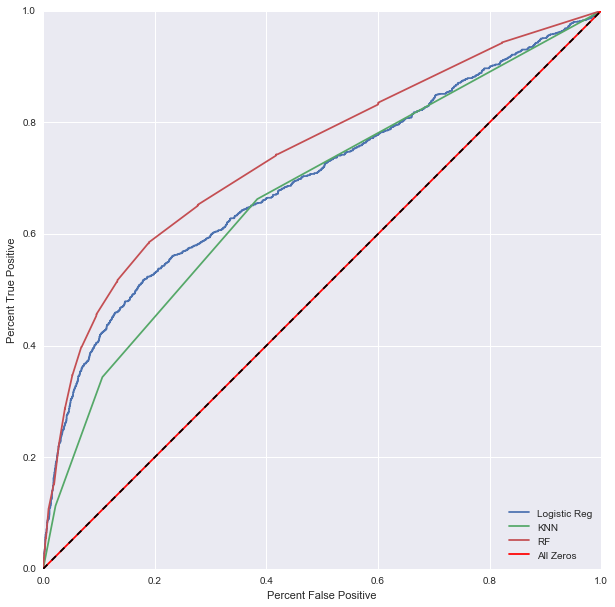

In [44]:
%matplotlib inline

fpr_zero, tpr_zero, _ = roc_curve(y_test, np.zeros(len(y_test)))

plt.figure(figsize=(10, 10))
plt.plot(fpr_lr, tpr_lr, label='Logistic Reg')
plt.plot(fpr_knn, tpr_knn, label='KNN')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_zero, tpr_zero, label='All Zeros', color="red")# Equivalent to Diagonal
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.xlabel('Percent False Positive')
plt.ylabel('Percent True Positive')
plt.show()

## Stratified 10 Fold Cross Validation on Test Data
Using the best parameters from grid search for Logistic Regression, KNN, and Random Forest

In [45]:
#******************************************************************************
#***************************** K Fold Parameters ******************************
#******************************************************************************

############################ Logistic Regression ##############################
clf_name='Logistic Regression'
kf_payload_lr = [clf_name, gs_lr.best_estimator_]

#################################### KNN ######################################
clf_name='K Nearest Neighbors'
kf_payload_knn = [clf_name, gs_knn.best_estimator_]

################################ Random Forest ################################
clf_name='Random Forest'
kf_payload_rf = [clf_name, gs_rf.best_estimator_]

In [46]:
# Could use cross_val_score instead
# Cross Validation Object

import scipy as sp
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, h #m-h, m+h

from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train,
                           n_folds=10,
                           random_state=1)

# Source: Python Machine Learning by Sebastian Raschka
def kfold_estimator(X_train, y_train, kfold, pipe_payload):
    clf_name = pipe_payload[0] # assigns name
    pipe = pipe_payload[1] # assigns pipeline
    scores = []
    print(clf_name)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for k, (train, test) in enumerate(kfold):
            pipe.fit(X_train[train], y_train[train])
            score = pipe.score(X_train[test], y_train[test])
            scores.append(score)
            print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
                  np.bincount(y_train[train]), score))

    print('\nCV accuracy: %.3f +/- %.3f' % mean_confidence_interval(scores, confidence=0.95))
    print()
    return [clf_name, mean_confidence_interval(scores, confidence=0.95)]
    
metrics_lr = kfold_estimator(X_train, y_train, kfold, kf_payload_lr)
metrics_knn = kfold_estimator(X_train, y_train, kfold, kf_payload_knn)
metrics_rf = kfold_estimator(X_train, y_train, kfold, kf_payload_rf)

Logistic Regression
Fold: 1, Class dist.: [16546  4765], Acc: 0.622
Fold: 2, Class dist.: [16546  4765], Acc: 0.613
Fold: 3, Class dist.: [16546  4765], Acc: 0.618
Fold: 4, Class dist.: [16546  4765], Acc: 0.635
Fold: 5, Class dist.: [16546  4765], Acc: 0.622
Fold: 6, Class dist.: [16547  4766], Acc: 0.632
Fold: 7, Class dist.: [16547  4766], Acc: 0.628
Fold: 8, Class dist.: [16547  4766], Acc: 0.622
Fold: 9, Class dist.: [16547  4766], Acc: 0.625
Fold: 10, Class dist.: [16547  4766], Acc: 0.628

CV accuracy: 0.624 +/- 0.005

K Nearest Neighbors
Fold: 1, Class dist.: [16546  4765], Acc: 0.768
Fold: 2, Class dist.: [16546  4765], Acc: 0.762
Fold: 3, Class dist.: [16546  4765], Acc: 0.758
Fold: 4, Class dist.: [16546  4765], Acc: 0.767
Fold: 5, Class dist.: [16546  4765], Acc: 0.762
Fold: 6, Class dist.: [16547  4766], Acc: 0.757
Fold: 7, Class dist.: [16547  4766], Acc: 0.771
Fold: 8, Class dist.: [16547  4766], Acc: 0.760
Fold: 9, Class dist.: [16547  4766], Acc: 0.771
Fold: 10, Class 

## Analysis of Results
The above shows each iteration of the stratified 10 fold cross validation for each model on the test data. The models used the training data and return very similar results. RF continued to be the best performer with a average accuracy of 80.6% with a 95% confidence interval of .801 to .811. KNN also did decently with average accuracy of .788 and a 95% confidence level of +/- .006. In last place, is Logistic regression average an accuracy of .646 and a 95% confidence level of +/- .006. The stratified K-fold cross validation gave stable results.

Although RF was the best performer, because it used the full explanatory variables, it was over 5 times slower than KNN or Logistic Regression using 3 principle components. This could be a significant problem on larger data sets or where time-to-classification is a priority, such as a credit card application. 

Feature ranking:
1. BILL_AMT1_Sept (0.086271)
2. PAY_AMT2_Aug (0.082551)
3. AGE (0.071030)
4. BILL_AMT3_July (0.068036)
5. BILL_AMT2_Aug (0.062833)
6. PAY_AMT6_April (0.062655)
7. PAY_AMT1_Sept (0.062641)
8. BILL_AMT6_April (0.057856)
9. PAY_AMT3_July (0.056656)
10. BILL_AMT4_June (0.050148)
11. PAY_AMT5_May (0.049983)
12. BILL_AMT5_May (0.049773)
13. PAY_AMT4_June (0.047865)
14. PAY_0_Sept (0.030623)
15. AGE_range (0.021061)
16. PAY_2_Aug (0.019749)
17. EDUCATION (0.015986)
18. PAY_3_July (0.015871)
19. PAY_4_June (0.013441)
20. PAY_6_April (0.012543)
21. PAY_5_May (0.011120)
22. isGradSchool (0.010958)
23. default payment next month (0.008785)
24. SEX (0.008102)
25. isMale (0.007932)
26. Marriage_Married (0.007573)
27. Marriage_Single (0.007389)
28. Marriage_Others (0.000569)


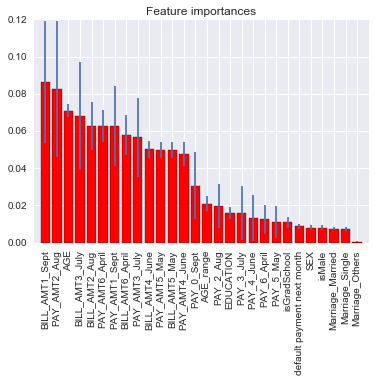

In [56]:
# Adapted from scikitlearn examples
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
# Build a forest and compute the feature importances
# Original example used ExtraTreesClassifier but the same result is produced
forest = RandomForestClassifier(random_state=1, n_jobs=-1)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

X_names_in_order= []
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_names[indices[f]], importances[indices[f]]))
    X_names_in_order.append(X_names[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X_names_in_order, rotation=90 )
plt.xlim([-1, X.shape[1]])
plt.show()

## Feature Importance
While BILL\_AMT1\_Sept and PAY\_AMT2\_Aug are no surprise, the AGE feature is a surprise when compared to the PCA and LDA result which had little importance for these feature (see below). The interwine of BILL\_ and PAY\_ is recognition of the relationship of these sets of features.

## Determing Risk Groups
All companies have limited resources, therefore, limiting the amount of overhead is key to keeping costs under control. When a credit card company needs to protect itself one way is to control risk. Using the RF classifier, the probability of default was determined for each observation and grouped into 3 risk buckets: low, elevated, and high. The low group had a probability of default less than .3, the elevated risk group had a probability of default between .3 and .7, and lastly the high risk group had a probability between .7 and 1. With this information a company can now take mitigating actions to prevent loss due to default. 

Pipeline(steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])


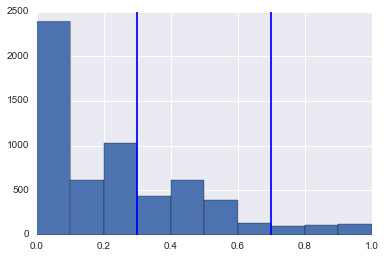

In [57]:
# From the gridsearch previously done, gs_rf is the 
# Random Forest object of the results

# Set the best model as deteremined by gridsearch
gs_rf_best_clf = gs_rf.best_estimator_
print(gs_rf_best_clf)
# Train the best model on the training data again
gs_rf_best_clf.fit(X_train, y_train)
# Produce the probability of being a '1' aka 'default'
y_pred_proba = gs_rf_best_clf.predict_proba(X_test)[:, 1]
plt.hist(y_pred_proba)
plt.axvline(.70)
plt.axvline(.30)

In [58]:
risk_data = pd.DataFrame({'Default':y_test, 'Risk_Cat':pd.cut(y_pred_proba, [-.1,.3,.7,1],3,labels=['low','elevated','high'])})
risk_data_x = risk_data.groupby(['Risk_Cat'])
print(risk_data_x.count(), "\n")
print(risk_data_x.sum()/risk_data_x.count())

          Default
Risk_Cat         
low          4030
elevated     1567
high          324 

           Default
Risk_Cat          
low       0.108685
elevated  0.428845
high      0.793210


## Important Attirbutes as Determined by PCA and LDA

In [59]:
#PCA or LDA code
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.lda import LDA

#copy the data to use code from sample
#X = cc_data_Xs
# y = cc_data_target
target_names = X_names

pca = PCA(n_components=4)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=4)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

pca: [[ -8.52847865e-08   2.84917570e-08   3.18875724e-06   1.37355378e-06
    1.82636400e-06   1.80822076e-06   1.82550194e-06   1.85943845e-06
    1.92324403e-06   4.45908342e-01   4.40285624e-01   4.28771056e-01
    3.97714441e-01   3.70059574e-01   3.53820172e-01   2.51169500e-02
    2.85924118e-02   2.39220952e-02   1.93798479e-02   1.88567055e-02
    2.02067748e-02  -3.61821229e-08   2.72023306e-07   8.52847865e-08
   -3.02217961e-08   7.36657603e-08  -1.16137240e-08  -6.20520362e-08]
 [ -3.51218712e-07  -8.43946089e-07   1.48946097e-06   1.28266433e-06
    1.62837634e-06   4.64954509e-07  -1.21723231e-06  -2.61065062e-06
   -3.59641408e-06   5.52247481e-01   3.94524819e-01   4.20940896e-02
   -2.55404312e-01  -4.19891919e-01  -4.75538942e-01  -4.71120784e-02
   -1.79104692e-01  -1.44345093e-01  -1.02395486e-01  -6.49924882e-02
    8.98328586e-03  -4.83653540e-08   2.10039643e-07   3.51218712e-07
   -6.42798653e-07   9.87839860e-09   2.42400613e-08  -3.41184599e-08]
 [  8.9834468

C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [60]:
%matplotlib inline
# this function definition just formats the weights into readable strings
# you can skip it without loss of generality to the Data Science content
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array
  
# now let's get to the Data Analytics!
pca_weight_strings = get_feature_names_from_weights(pca.components_, X_names) 
lda_weight_strings = get_feature_names_from_weights(lda.scalings_.T, X_names) 

# create some pandas dataframes from the transformed outputs
df_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])
df_lda = pd.DataFrame(X_lda,columns=[lda_weight_strings])

print("Variance explained for the 4 components:")
print(pca.explained_variance_ratio_ , "\n")

print(pca_weight_strings[0], "\n")
print(pca_weight_strings[1], "\n")
print(pca_weight_strings[2], "\n")
print(pca_weight_strings[3], "\n")
print(lda_weight_strings)

Variance explained for the 4 components:
[ 0.84919312  0.048262    0.02714446  0.01609928] 

-0.00* +0.00*EDUC +0.00* +0.00*PAY_0 +0.00*PAY_ +0.00*PAY_3 +0.00*PAY_4 +0.00*PAY_ +0.00*PAY_6_ +0.45*BILL_AMT1 +0.44*BILL_AMT +0.43*BILL_AMT3 +0.40*BILL_AMT4 +0.37*BILL_AMT +0.35*BILL_AMT6_ +0.03*PAY_AMT1 +0.03*PAY_AMT +0.02*PAY_AMT3 +0.02*PAY_AMT4 +0.02*PAY_AMT +0.02*PAY_AMT6_ -0.00*default payment next  +0.00*AGE_ +0.00*i -0.00*isGradS +0.00*Marriage_Ma -0.00*Marriage_O -0.00*Marriage_S  

-0.00* -0.00*EDUC +0.00* +0.00*PAY_0 +0.00*PAY_ +0.00*PAY_3 -0.00*PAY_4 -0.00*PAY_ -0.00*PAY_6_ +0.55*BILL_AMT1 +0.39*BILL_AMT +0.04*BILL_AMT3 -0.26*BILL_AMT4 -0.42*BILL_AMT -0.48*BILL_AMT6_ -0.05*PAY_AMT1 -0.18*PAY_AMT -0.14*PAY_AMT3 -0.10*PAY_AMT4 -0.06*PAY_AMT +0.01*PAY_AMT6_ -0.00*default payment next  +0.00*AGE_ +0.00*i -0.00*isGradS +0.00*Marriage_Ma +0.00*Marriage_O -0.00*Marriage_S  

0.00* +0.00*EDUC +0.00* -0.00*PAY_0 -0.00*PAY_ -0.00*PAY_3 -0.00*PAY_4 -0.00*PAY_ -0.00*PAY_6_ -0.18*BILL_AMT1 -0.0

### PCA and LDA Analysis
As can be observed with the PCA analysis, the first 3 Principle Components account for the majority of the variability of the input. PCA is a systematic way to reduce the number of inputs to a manageable size using an algorithm rather than eyeballs selecting variables, though with this number of attributes, both are valid. Of these 3 Principle Components, the first one has coefficients for BILL_AMT attributes, with minor weightings for PAY_AMT attributes and nothing or almost nothing for the other attributes. The LDA analysis shows much the same, although this algorithm chose PAY_ instead of BILL_AMT. PCA was superior but the conclusions are similar. Specifically, that marriage, age, education, and balance limits had little (LDA) or no (PCA) correlation to defaults.

## Deployment
* The models provide a starting point for interested parties, identifying the most fruitful models with the data available. From this point, a conversation would be in order with the prospective model users about additional data that would enhance predictions and cover corner cases, and request additional data to test and validate again. 
* To measure the value, one would implement the model in a business setting. This is envisioned as  customer advisers calling customers that are going to default to offer help or whatever action the business sees fit to take to avoid that outcome. At the point where the CC company has fewer defaults and people have fewer defaults to struggle with, then you have a valid measurement: old default rate versus new default rate.
* Updates to the model would be determined by its overall impact to the customer and company, combined with new ideas that develop as the model is tweaked to come up with better predictions. At some point the tweaks will not significantly improve the prediction at which time the company may decide to just keep it as-is and move the resource to more productive problems that need to be tackled. 
* For example, adding a credit score to the prediction should, theoretically, greatly improve prediction, including those who probabilistically will default and more concretely identifying those at risk.

# TASK TWO!
This is looking for a second prediction:
- We will predict users wtih a high balance limit. Set up originally in the data munging section at the top as isLimitBal_gt_250K
- The business justification is the CC company can use these predictions to understand the pool of candidates, by the data, that do have a high balance limit (true positives) and those that should have a high balance limit (the false positives).
 - In other words, even if the high balance prediction does not match actual high balance limit, it is still an indicator that the data supports a high balance limit. 
- Special offerings can be designed to target high balance limit customers.

In [61]:
# Seperate target data and explanatory data to NumPy arrays, as before
# Start with the original, prepared data
y = cc_data['isLimitBal_gt_250K'].values
# don't forget to drop the original data too
X = cc_data.drop(['isLimitBal_gt_250K', 'LIMIT_BAL_range'], axis='columns').values

# Column names for labeling
X_names = cc_data.drop(['isLimitBal_gt_250K', 'LIMIT_BAL_range'], axis='columns').columns

In [62]:
# Updated train and test sets using the same 80/20 split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=1)

In [63]:
#
# Very similar pipelines and grid search
#
###############################################################################
########################## Logistic Regression Pipe ###########################
###############################################################################
clf_name='Logistic Regression'
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', LogisticRegression(random_state=1))])
param_grid_lr = [{'pca__n_components':[2,3,4],
                  'clf__C': [.1,1,10,100],
                  'clf__penalty': ['l1','l2'],
                  'clf__class_weight': ['balanced', None]}]

payload_lr = [clf_name, pipe_lr, param_grid_lr]

###############################################################################
################################## KNN Pipe ###################################
###############################################################################
clf_name='K Nearest Neighbors'
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', KNeighborsClassifier())])

param_grid_knn = [{'pca__n_components':[2,3,4],
                   'clf__n_neighbors': [2,4,6,8], 
                   'clf__p': [1,2]}]

payload_knn = [clf_name, pipe_knn, param_grid_knn]

###############################################################################
############################## Randomforest Pipe ##############################
###############################################################################
# No need to scale or use PCA on RF
clf_name='Random Forest'
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=1,
                                                   n_jobs=1))])

param_grid_rf = [{'clf__criterion': ['entropy','gini'],
                  'clf__n_estimators': [10,15,20], 
                  'clf__max_features': ['auto', 'sqrt', 'log2', None],
                  'clf__class_weight': ['balanced', 'balanced_subsample', None]}]

payload_rf = [clf_name, pipe_rf, param_grid_rf]

In [64]:
# Using the grid_searcher2 function, run Logistic Regression, KNN, and Random Forest Models
gs_lr = grid_searcher2(X_train, y_train, payload_lr)
gs_knn = grid_searcher2(X_train, y_train, payload_knn)
gs_rf = grid_searcher2(X_train, y_train, payload_rf)

Logistic Regression
Best F-Score:  0.527754241435
Best Parameters:  {'clf__penalty': 'l1', 'pca__n_components': 4, 'clf__class_weight': 'balanced', 'clf__C': 1}
Best Estimator:  Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=4, whiten=False)), ('clf', LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
K Nearest Neighbors
Best F-Score:  0.390237505571
Best Parameters:  {'clf__n_neighbors': 6, 'pca__n_components': 4, 'clf__p': 2}
Best Estimator:  Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=4, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n

In [65]:
%matplotlib inline

# split the same way
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=1)

print("Logistic Regression")
fpr_lr, tpr_lr = roc_data(gs_lr, X_train, y_train, X_test, y_test)
print("KNN")
fpr_knn, tpr_knn = roc_data(gs_knn, X_train, y_train, X_test, y_test)
print("Random Forest")
fpr_rf, tpr_rf = roc_data(gs_rf, X_train, y_train, X_test, y_test)

Logistic Regression
****************************************************
Classification Report:
Accuracy: 0.720
AUC: 0.795
             precision    recall  f1-score   support

      False       0.89      0.72      0.80      4554
       True       0.43      0.71      0.54      1367

avg / total       0.79      0.72      0.74      5921

****************************************************


KNN
****************************************************
Classification Report:
Accuracy: 0.797
AUC: 0.757
             precision    recall  f1-score   support

      False       0.82      0.95      0.88      4554
       True       0.63      0.29      0.40      1367

avg / total       0.77      0.80      0.77      5921

****************************************************


Random Forest
****************************************************
Classification Report:
Accuracy: 0.804
AUC: 0.811
             precision    recall  f1-score   support

      False       0.84      0.92      0.88      4554
      

### Review of Key Statistics
Reviewing the metrics of the classifiers above, Random Forest (RF) is the better predictor. RF has a superior AUC score of .804 and f1-score of .79. Also, the ROC curve further below shows the RF model has the best performing curve over all. Using the AUC value RF is still the better model.

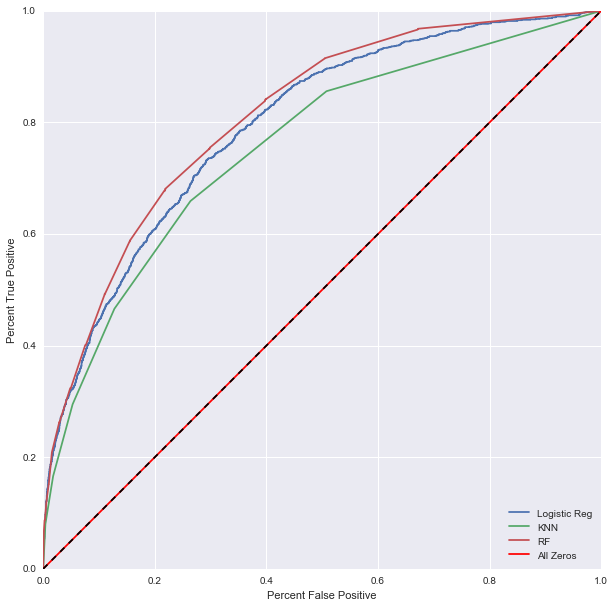

In [66]:
%matplotlib inline

fpr_zero, tpr_zero, _ = roc_curve(y_test, np.zeros(len(y_test)))

plt.figure(figsize=(10, 10))
plt.plot(fpr_lr, tpr_lr, label='Logistic Reg')
plt.plot(fpr_knn, tpr_knn, label='KNN')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_zero, tpr_zero, label='All Zeros', color="red")# Equivalent to Diagonal
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.xlabel('Percent False Positive')
plt.ylabel('Percent True Positive')
plt.show()

# Analysis
In this case, RF was better, but not by much. Logistic regression was close. This is important as the data scales up. If LR runs much faster, it may be worth the time / accuracy tradeoff.

In [67]:
#********************** K Fold - Use best parameters **************************

############################ Logistic Regression ##############################
clf_name='Logistic Regression'
kf_payload_lr = [clf_name, gs_lr.best_estimator_]

#################################### KNN ######################################
clf_name='K Nearest Neighbors'
kf_payload_knn = [clf_name, gs_knn.best_estimator_]

################################ Random Forest ################################
clf_name='Random Forest'
kf_payload_rf = [clf_name, gs_rf.best_estimator_]

In [68]:
# Cross Validation Object

kfold = StratifiedKFold(y=y_train,
                           n_folds=10,
                           random_state=1)

metrics_lr = kfold_estimator(X_train, y_train, kfold, kf_payload_lr)
metrics_knn = kfold_estimator(X_train, y_train, kfold, kf_payload_knn)
metrics_rf = kfold_estimator(X_train, y_train, kfold, kf_payload_rf)

Logistic Regression
Fold: 1, Class dist.: [16560  4751], Acc: 0.730
Fold: 2, Class dist.: [16561  4751], Acc: 0.700
Fold: 3, Class dist.: [16561  4751], Acc: 0.734
Fold: 4, Class dist.: [16561  4751], Acc: 0.712
Fold: 5, Class dist.: [16561  4751], Acc: 0.729
Fold: 6, Class dist.: [16561  4751], Acc: 0.712
Fold: 7, Class dist.: [16561  4751], Acc: 0.720
Fold: 8, Class dist.: [16561  4751], Acc: 0.721
Fold: 9, Class dist.: [16561  4751], Acc: 0.717
Fold: 10, Class dist.: [16561  4752], Acc: 0.724

CV accuracy: 0.720 +/- 0.007

K Nearest Neighbors
Fold: 1, Class dist.: [16560  4751], Acc: 0.796
Fold: 2, Class dist.: [16561  4751], Acc: 0.795
Fold: 3, Class dist.: [16561  4751], Acc: 0.802
Fold: 4, Class dist.: [16561  4751], Acc: 0.803
Fold: 5, Class dist.: [16561  4751], Acc: 0.794
Fold: 6, Class dist.: [16561  4751], Acc: 0.799
Fold: 7, Class dist.: [16561  4751], Acc: 0.799
Fold: 8, Class dist.: [16561  4751], Acc: 0.800
Fold: 9, Class dist.: [16561  4751], Acc: 0.799
Fold: 10, Class 

## Task Two Analysis
The results identify the group of people that should have a balance limit above 250k. For example, the credit card company can use the list of those that are predicted to have more than 250k, but do not, to generate a lead list for pursuing increased business by this group to consolidate credit cards with them. 

The accuracy is about 80% for both KNN (79.9% ±.2%) and Random Forest (80.5% ±.6%), with Random Forest being slightly more accurate. However, KNN using only 4 PCA components, runs much faster the Random Forest with all features with almost identical results. With many more thousands of customers in real world scenario, the speedier approach of KNN would be preferred. 

Remaining tasks could include:
- Cross referencing those that have not had a default in some business directed amount of time. 
- Cross reference customers who recently earned a bachelors degree with a special offering for student loan financing for a Masters degree.